In [1]:
from gradio_client import Client, handle_file

client = Client("prithivMLmods/Multimodal-OCR3")
result = client.predict(
	model_name="Chandra-OCR",
	text="what are the ft measurements that run east-west and north-south of this plot boundary?",
	image=handle_file('/content/Image 15-11-2025 at 1.04 PM.png'),
	max_new_tokens=2048,
	temperature=0.7,
	top_p=0.9,
	top_k=50,
	repetition_penalty=1.1,
	api_name="/generate_image"
)
print(result)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded as API: https://prithivmlmods-multimodal-ocr3.hf.space ✔
('Based on the provided site plan, the lot is bounded by two sets of coordinates defining its East-West (EW) and North-South (NS) extents. The measurements are:\n\n*   **East-West Boundary (X-axis):**\n    *   South boundary: `N 87°09\'50" E 50.00\'`\n    *   North boundary: `S 02°50\'10" E 127.50\'`\n\n*   **North-South Boundary (Y-axis):**\n    *   West boundary: `N 02°50\'10" W 127.50\'`\n    *   East boundary: `S 02°50\'10" E 127.50\'`', 'Based on the provided site plan, the lot is bounded by two sets of coordinates defining its East-West (EW) and North-South (NS) extents. The measurements are:\n\n*   **East-West Boundary (X-axis):**\n    *   South boundary: `N 87°09\'50" E 50.00\'`\n    *   North boundary: `S 02°50\'10" E 127.50\'`\n\n*   **North-South Boundary (Y-axis):**\n    *   West boundary: `N 02°50\'10" W 127.50\'`\n    *   East boundary: `S 02°50\'10" E 127.50\'`')


In [2]:
!pip install langchain_openai langchain langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
import os

llm = ChatOpenAI(model="gpt-4", temperature=0.1)

DIMENSIONS_GENERATION_SYSTEM = """You are a professional land developer and surveyor, given the description of the plot boundary dimensions respond in JSON format with the North-South and East-West Boundary Feet Measurements. If a boundary measurement is missing just place an empty string as the value. Example: { North_South: <Feet Measurement> or "", East_West: <Feet Measurement> or "" }"""

@staticmethod
def sqft_generation_user(description) -> str:
    return f"""Description: {description}"""

messages = [
            SystemMessage(content=DIMENSIONS_GENERATION_SYSTEM),
            HumanMessage(content=sqft_generation_user(result))
        ]
response = llm.invoke(messages)

print(response.content)


{
  "North_South": "127.50",
  "East_West": "50.00"
}


In [5]:
import json

boundary_measurements = json.loads(response.content)
print(boundary_measurements)

{'North_South': '127.50', 'East_West': '50.00'}


In [6]:
!pip install rectpack


  Preparing metadata (setup.py) ... done
  Created wheel for rectpack: filename=rectpack-0.2.2-py3-none-any.whl size=19333 sha256=612acb532c8d0dd8491d2fb80870ac82079e5015a1f4a2dfef08f39e842daf2c
  Stored in directory: /root/.cache/pip/wheels/ea/a4/a8/b4e6e7d9876ceee00dd69c64010a64b6f8818d3fda00abcdb5
Successfully built rectpack


In [7]:
plat_width = boundary_measurements["East_West"]
plat_length = boundary_measurements["North_South"]

from rectpack import newPacker

def pack_rectangles(plat_w, plat_h, lot_w, lot_h, allow_rotate=True):
    packer = newPacker(rotation=allow_rotate)

    packer.add_bin(plat_w, plat_h)

    # Add a large number of rectangles of the same size
    for _ in range(10000):
        packer.add_rect(lot_w, lot_h)

    packer.pack()

    placed = packer.rect_list()

    return {
        "count": len(placed),
        "placements": placed  # (bin_id, x, y, w, h)
    }

total_lots = pack_rectangles(
    plat_w=float(plat_width),
    plat_h=float(plat_length),
    lot_w=64,
    lot_h=20
)

print("Total lots:", total_lots["count"])


Total lots: 2


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary

%matplotlib inline
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [10]:
import os

full_dataset_len = len(os.listdir("/content/drive/MyDrive/Final_Dataset"))

print("Dataset Length: ", full_dataset_len, "Dataset Contents: ", os.listdir("/content/drive/MyDrive/Final_Dataset"))

training_data = datasets.ImageFolder("/content/drive/MyDrive/Final_Dataset/train")
validation_data = datasets.ImageFolder("/content/drive/MyDrive/Final_Dataset/validation")
print("Train Classes: ", training_data.classes)
print("Val Classes: ", validation_data.classes)

# for sample in list(data.samples):
#   print(sample)

Dataset Length:  2 Dataset Contents:  ['train', 'validation']
Train Classes:  ['Eighty', 'Fifty', 'Fourty', 'Ninety', 'Ten', 'Thirty', 'Twenty']
Val Classes:  ['Eighty', 'Fifty', 'Fourty', 'Ninety', 'Ten', 'Thirty', 'Twenty']


In [11]:
img_w, img_h = 512, 512
batch_size = 20

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_h, img_w)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.GaussianBlur(kernel_size=3, sigma=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((img_h, img_w)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [12]:
image_datasets = {
    "train" : datasets.ImageFolder("/content/drive/MyDrive/Final_Dataset/train", data_transforms["train"]),
    "validation" : datasets.ImageFolder("/content/drive/MyDrive/Final_Dataset/validation", data_transforms["validation"])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=4)
}

print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['validation'])}")

Training samples: 78
Validation samples: 20


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [23]:
class LotPredictor(nn.Module):
  def __init__(self, input_channels=3, len_classes=len(image_datasets["train"].classes)):
    super(LotPredictor, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
        nn.ReLU(), # Can try nn.ReLU(inplace=True)
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(1024, 2048, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(1024 * (img_h//64) * (img_w//64), 2048),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(2048, len_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


model = LotPredictor().to(device)
print(model)
summary(model, (3, img_h, img_w))

LotPredictor(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [29]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
  best_val_acc = 0
  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      loss = 0.0
      correct = 0

      for inputs, labels in tqdm(dataloaders[phase], desc=phase):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            model_loss = criterion(outputs, labels)

            if phase == 'train':
                model_loss.backward()
                optimizer.step()

        loss += model_loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

      epoch_loss = loss / len(image_datasets[phase])
      epoch_acc = correct.double() / len(image_datasets[phase])

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      if phase == 'validation':
        if epoch_acc > best_val_acc:
          best_val_acc = epoch_acc
          torch.save(model.state_dict(), "best_model.pt")
          print("✅ Best model saved!")

    print()
  model.load_state_dict(torch.load("best_model.pt", map_location=device))
  model.eval()
  return model

trained_model=train_model(model, dataloaders, criterion, optimizer, num_epochs=50)

print("Training complete!")

Epoch 1/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


train Loss: 0.7736 Acc: 0.7308


validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


validation Loss: 2.8053 Acc: 0.2500
✅ Best model saved!

Epoch 2/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


train Loss: 0.8483 Acc: 0.6667


validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


validation Loss: 2.1131 Acc: 0.3500
✅ Best model saved!

Epoch 3/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


train Loss: 0.7334 Acc: 0.7051


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 2.7194 Acc: 0.4000
✅ Best model saved!

Epoch 4/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


train Loss: 0.7327 Acc: 0.7436


validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


validation Loss: 2.8259 Acc: 0.4000

Epoch 5/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


train Loss: 0.8079 Acc: 0.7436


validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


validation Loss: 2.7143 Acc: 0.4500
✅ Best model saved!

Epoch 6/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


train Loss: 0.7280 Acc: 0.7436


validation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


validation Loss: 2.3812 Acc: 0.2500

Epoch 7/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train Loss: 0.7060 Acc: 0.7051


validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


validation Loss: 2.7926 Acc: 0.3500

Epoch 8/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


train Loss: 0.7047 Acc: 0.7692


validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


validation Loss: 2.4911 Acc: 0.4000

Epoch 9/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


train Loss: 0.6785 Acc: 0.7179


validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


validation Loss: 2.8513 Acc: 0.4000

Epoch 10/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


train Loss: 0.6596 Acc: 0.7564


validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


validation Loss: 3.2200 Acc: 0.4000

Epoch 11/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


train Loss: 0.6577 Acc: 0.7692


validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


validation Loss: 3.2149 Acc: 0.4000

Epoch 12/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train Loss: 0.6036 Acc: 0.7949


validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


validation Loss: 4.3830 Acc: 0.3000

Epoch 13/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


train Loss: 0.6213 Acc: 0.7692


validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


validation Loss: 2.7799 Acc: 0.4000

Epoch 14/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


train Loss: 0.6887 Acc: 0.7308


validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


validation Loss: 3.3896 Acc: 0.2000

Epoch 15/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


train Loss: 0.6466 Acc: 0.7821


validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


validation Loss: 2.8731 Acc: 0.3000

Epoch 16/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train Loss: 0.5999 Acc: 0.7821


validation: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


validation Loss: 4.4652 Acc: 0.4000

Epoch 17/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


train Loss: 0.5304 Acc: 0.7949


validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


validation Loss: 3.7804 Acc: 0.3500

Epoch 18/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


train Loss: 0.5012 Acc: 0.8077


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 4.1847 Acc: 0.3000

Epoch 19/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train Loss: 0.5724 Acc: 0.7692


validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


validation Loss: 3.5572 Acc: 0.3500

Epoch 20/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


train Loss: 0.5814 Acc: 0.8077


validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


validation Loss: 4.7873 Acc: 0.4000

Epoch 21/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train Loss: 0.4163 Acc: 0.8205


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 3.9233 Acc: 0.4000

Epoch 22/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


train Loss: 0.3779 Acc: 0.8462


validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


validation Loss: 4.3912 Acc: 0.4000

Epoch 23/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


train Loss: 0.4593 Acc: 0.8205


validation: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


validation Loss: 4.8336 Acc: 0.4000

Epoch 24/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


train Loss: 0.5931 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


validation Loss: 3.5048 Acc: 0.4000

Epoch 25/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


train Loss: 0.5544 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 4.3294 Acc: 0.4000

Epoch 26/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train Loss: 0.5078 Acc: 0.7821


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 3.3086 Acc: 0.4000

Epoch 27/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


train Loss: 0.4025 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


validation Loss: 6.1588 Acc: 0.4000

Epoch 28/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


train Loss: 0.4829 Acc: 0.8462


validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


validation Loss: 4.2734 Acc: 0.4000

Epoch 29/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


train Loss: 0.4517 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


validation Loss: 3.4167 Acc: 0.3500

Epoch 30/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


train Loss: 0.5351 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


validation Loss: 4.3488 Acc: 0.3500

Epoch 31/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


train Loss: 0.3619 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


validation Loss: 4.2035 Acc: 0.3500

Epoch 32/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


train Loss: 0.3355 Acc: 0.8462


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 6.9178 Acc: 0.4000

Epoch 33/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train Loss: 0.4680 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


validation Loss: 5.1879 Acc: 0.3500

Epoch 34/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


train Loss: 0.4683 Acc: 0.8462


validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


validation Loss: 5.0367 Acc: 0.3500

Epoch 35/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train Loss: 0.3153 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


validation Loss: 7.7010 Acc: 0.3500

Epoch 36/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


train Loss: 0.3971 Acc: 0.8590


validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


validation Loss: 6.6992 Acc: 0.4000

Epoch 37/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


train Loss: 0.3851 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


validation Loss: 6.1476 Acc: 0.3500

Epoch 38/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


train Loss: 0.4454 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


validation Loss: 6.2080 Acc: 0.3500

Epoch 39/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


train Loss: 0.4031 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


validation Loss: 5.7394 Acc: 0.4000

Epoch 40/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


train Loss: 0.3482 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 8.1574 Acc: 0.4000

Epoch 41/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


train Loss: 0.4640 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


validation Loss: 9.9255 Acc: 0.4000

Epoch 42/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


train Loss: 0.3203 Acc: 0.9103


validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


validation Loss: 10.0562 Acc: 0.3000

Epoch 43/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


train Loss: 1.0815 Acc: 0.8205


validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


validation Loss: 3.2361 Acc: 0.2500

Epoch 44/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


train Loss: 0.6014 Acc: 0.7949


validation: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


validation Loss: 4.2338 Acc: 0.4000

Epoch 45/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


train Loss: 0.4517 Acc: 0.8077


validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


validation Loss: 4.7664 Acc: 0.2500

Epoch 46/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train Loss: 0.3004 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


validation Loss: 5.1377 Acc: 0.4000

Epoch 47/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train Loss: 0.3900 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


validation Loss: 6.3120 Acc: 0.4000

Epoch 48/50
----------


train: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


train Loss: 0.4549 Acc: 0.8077


validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


validation Loss: 3.9463 Acc: 0.2500

Epoch 49/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


train Loss: 0.3044 Acc: 0.8846


validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


validation Loss: 12.1424 Acc: 0.3500

Epoch 50/50
----------


train: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


train Loss: 0.2946 Acc: 0.8718


validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


validation Loss: 11.6624 Acc: 0.4000

Training complete!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy: 0.4500


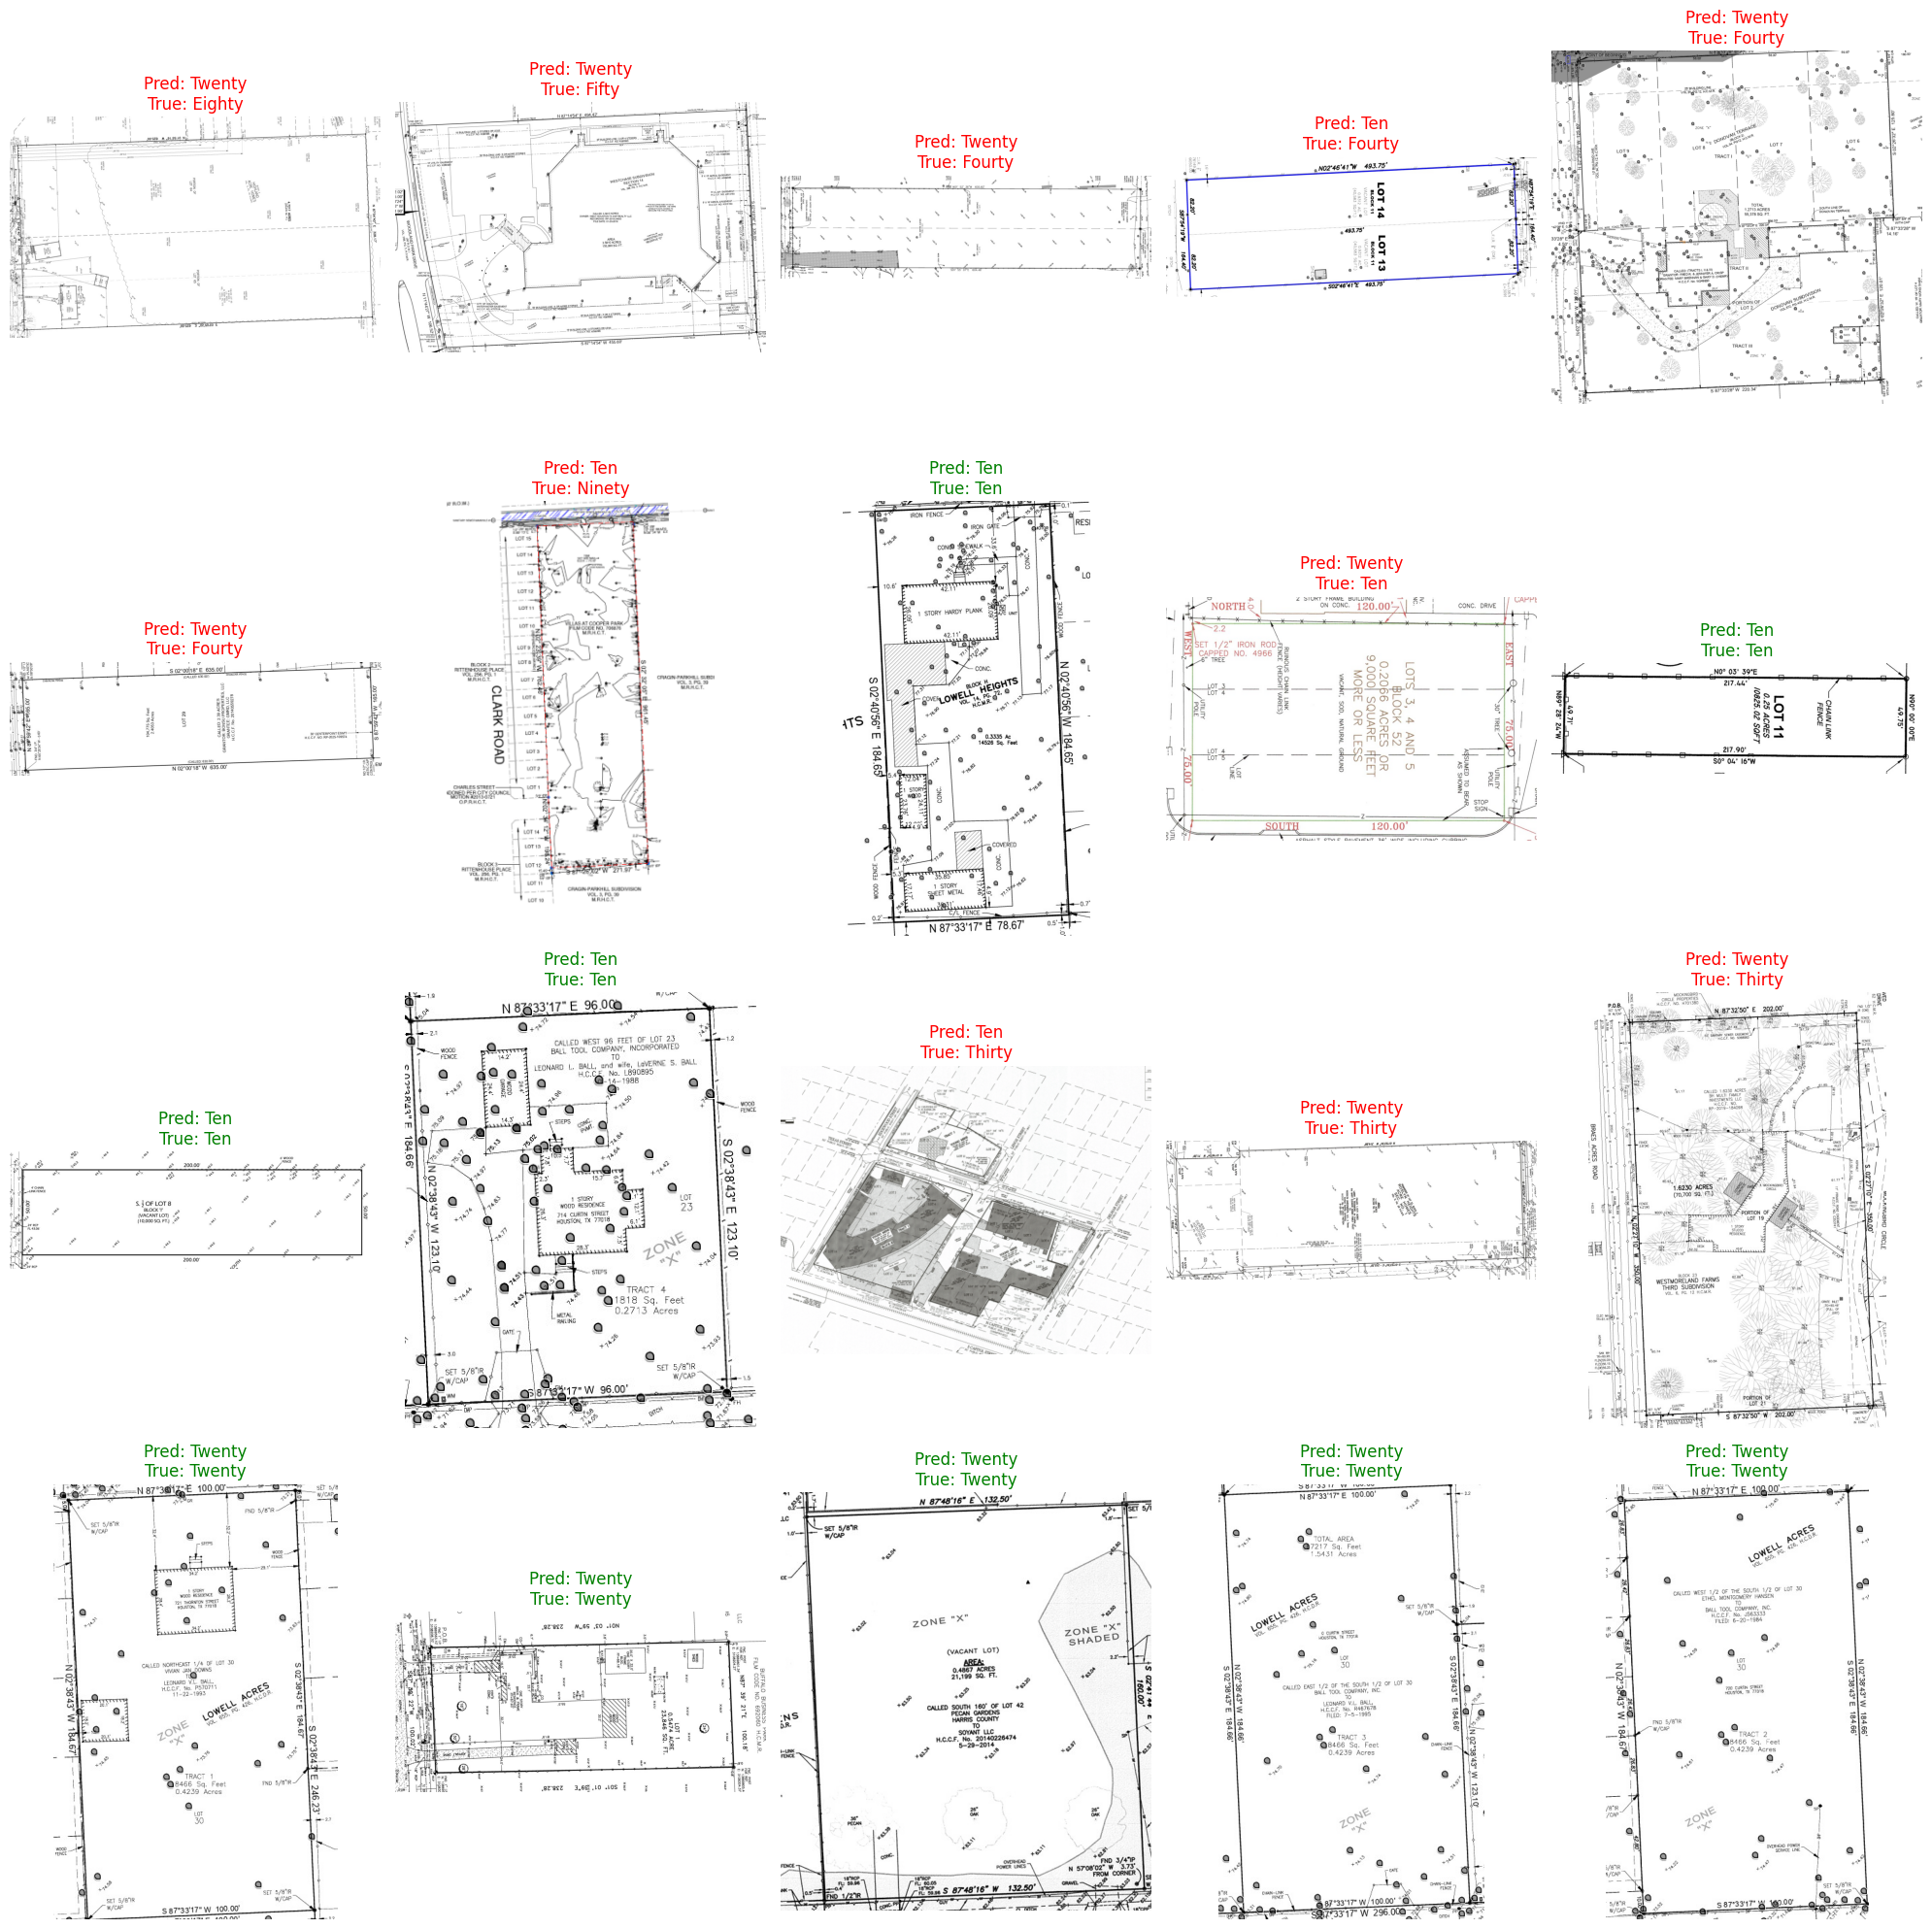

In [30]:
def evaluate_model(model, dataloader):
  model.eval()  # Set the model to evaluation mode
  all_preds = []
  all_labels = []

  with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.numpy())

  return all_preds, all_labels

val_preds, val_labels = evaluate_model(trained_model, dataloaders['validation'])

accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

def plot_results(images, preds, labels):
  fig, axs = plt.subplots(4, 5, figsize=(20, 20))
  for i, (img_path, pred, label) in enumerate(zip(image_datasets['validation'].imgs, preds, labels)):
    Label = ""
    if pred == 0:
      Label = "Eighty"
    elif pred == 1:
      Label = "Fifty"
    elif pred == 2:
      Label = "Forty"
    elif pred == 3:
      Label = "Ninety"
    elif pred == 4:
      Label = "Ten"
    elif pred == 5:
      Label = "Thirty"
    elif pred == 6:
      Label = "Twenty"
    img = plt.imread(img_path[0])
    ax = axs[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    color = 'green' if pred == label else 'red'
    ax.set_title(f"Pred: {Label}\nTrue: {image_datasets['validation'].classes[label]}", color=color)
  plt.tight_layout()
  plt.show()

plot_results(image_datasets['validation'].imgs, val_preds, val_labels)

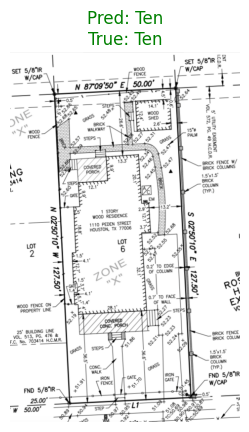

In [31]:
from PIL import Image
from google.colab import files

sample_transform = transforms.Compose([
      transforms.Resize((img_h, img_w)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

sample_dataset = datasets.ImageFolder("/content/drive/MyDrive/Sample", sample_transform)

sample_dataloader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

def sample_evaluation(model, dataloader):
  model.eval()

  with torch.no_grad():
    for inputs, labels in dataloader:
      input = inputs.to(device)
      output = model(input)
      _, pred = torch.max(output, 1)

  return pred, labels

pred, label = sample_evaluation(trained_model, sample_dataloader)

# accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
# print(f"Validation Accuracy: {accuracy:.4f}")

img = Image.open("/content/Image 15-11-2025 at 1.04 PM.png")

plt.imshow(img)
color = 'green' if training_data.classes[pred[0]] == "Ten" else 'red'
plt.title(f"Pred: {training_data.classes[pred[0]]}\nTrue: Ten", color=color)
plt.axis('off')
plt.show()

In [32]:
cnn_lot_predictions = 0

if pred == 0:
  cnn_lot_predictions = 75
elif pred == 1:
  cnn_lot_predictions = 45
elif pred == 2:
  cnn_lot_predictions = 35
elif pred == 3:
  cnn_lot_predictions = 85
elif pred == 4:
  cnn_lot_predictions = 5
elif pred == 5:
  cnn_lot_predictions = 25
elif pred == 6:
  cnn_lot_predictions = 15

final_lot_prediction = (total_lots["count"] + cnn_lot_predictions) / 2

print(f"Expected Lot Prediction: {1}")
print(f"Final Lot Prediction: {final_lot_prediction}")

Expected Lot Prediction: 1
Final Lot Prediction: 3.5
